In [288]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [4]:
df_original = pd.read_csv('drive/My Drive/data/application_train.csv')
df_test_original = pd.read_csv('drive/My Drive/data/application_test.csv') 

df = df_original
df_test = df_test_original

In [132]:
#欠損値除外
df.dropna(thresh=304000, axis=1, inplace=True) 
df.dropna(how='any', axis=0, inplace=True) 

df_test['TARGET'] = '' #↓の処理の際にTARGETカラムが無いと処理できない為、追加
df_test = df_test[df.columns] #訓練データとカラムを合わせる
df_test = df_test.fillna(0) #欠損値には0を適用

df = df.select_dtypes(exclude=["object"]) #オブジックト列削除

In [133]:
X = df.drop('TARGET',axis=1).values
y = df['TARGET'].values

【問題1】クロスバリデーション
事前学習期間は検証データを分割しておき、それに対して指標値を計算することで検証を行っていました。しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション を行います。


具体的には分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割を行う関数はscikit-learnにKFoldとして用意されています。

In [96]:
kf = KFold(n_splits = 5, shuffle = True)

scores = []

for train_id,test_id in kf.split(X):
  #訓練データ、テストデータ作成
  x_train,y_train = X[train_id], y[train_id]
  x_test,y_test = X[test_id], y[test_id]

  #学習
  tree = DecisionTreeClassifier(random_state=0)
  tree.fit(x_train,y_train)
  Y_pred = tree.predict(x_test)
  
  #スコアリング、格納
  score = accuracy_score(y_test,Y_pred)
  scores.append(score)

In [100]:
scores = np.array(scores)
print(scores)
print(f'平均値は　{scores.mean()}')

[0.84647085 0.84852067 0.84546678 0.84746987 0.84666535]
平均値は　0.8469187059703509


【問題2】グリッドサーチ
これまで分類器のパラメータは基本的にデフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになりますが、パラメータは状況に応じて最適なものを選ぶ必要があります。パラメータを探索するために グリッドサーチ と呼ばれる総当たり的手法が一般的に利用されます。


グリッドサーチをパイプラインの中に組み込みましょう。

In [108]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [113]:
param_grid = [{
    'max_depth' : [3, 20, 50],
    'min_samples_split' : [3, 20, 30]
}]

In [109]:
estimator = DecisionTreeClassifier(random_state=0)
cv = 5

turned_model = GridSearchCV(estimator = estimator,
                            param_grid = param_grid,
                            cv = cv, return_train_score = False)

In [118]:
turned_model.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [3, 20, 50],
                          'min_samples_split': [3, 20, 30]}],
             

In [122]:
pd.DataFrame(turned_model.cv_results_).T

0  ...                                           8
mean_fit_time                                            0.844877  ...                                     5.75666
std_fit_time                                            0.0692945  ...                                    0.179929
mean_score_time                                         0.0140081  ...                                   0.0255396
std_score_time                                         0.00038434  ...                                 0.000564471
param_max_depth                                                 3  ...                                          50
param_min_samples_split                                         3  ...                                          30
params                   {'max_depth': 3, 'min_samples_split': 3}  ...  {'max_depth': 50, 'min_samples_split': 30}
split0_test_score                                        0.919456  ...                                    0.888566
split1_test_score                                        0.919477  ...                                    0.887625
split2_test_score                                        0.919477  ...                                    0.889853
split3_test_score                                        0.919477  ...                                    0.890322
split4_test_score                                        0.919454  ...                                    0.888352
mean_test_score                                          0.919468  ...                                    0.888944
std_test_score                                        1.10442e-05  ...                                 0.000995971
rank_test_score                                                 1  ...                                           6

[15 rows x 9 columns]

【問題3】Kernelからの調査
KaggleのKernelから自身にはなかったアイデアを見つけ出して、列挙してください。そして、効果があると考えられるものを検証してください。

*   days_birthカラムのダミー変数化（ex. 20代=2 30代=3）
*   カラム同士を掛け合わせ、新たな変数を作成する(ex. df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY'])
*   変数のグループを作り、その他の変数との合計や平均、偏差を計算の上、ダミー変数化する
*   bureau.csv（Home Credit社以外のクレジットビューローでの融資情報）を活用していた
*   性質の似た同士の変数を掛け合わせてダミー変数を作成していた。またそれとは別に、異なる係数を掛け、sumしたダミー変数を作成していた（df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']）

In [214]:
df = df_original

In [215]:
df = df[df['AMT_INCOME_TOTAL'] < 20000000]
df = df[df['CODE_GENDER'] != 'XNA']
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

In [216]:
df['AGE'] = abs(df['DAYS_BIRTH'] // 365)
df.loc[df['AGE'] < 30, 'AGE_RANGE'] = 1
df.loc[(df['AGE'] >= 30) & (df['AGE'] < 45), 'AGE_RANGE'] = 2
df.loc[(df['AGE'] >= 45) & (df['AGE'] < 60), 'AGE_RANGE'] = 3
df.loc[df['AGE'] >= 60, 'AGE_RANGE'] = 4

In [217]:
df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']    
df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

In [218]:
df_temp = df #ここから問題4で使用

In [180]:
#欠損値除外
df.dropna(thresh=304000, axis=1, inplace=True) 
df.dropna(how='any', axis=0, inplace=True) 

df = df.select_dtypes(exclude=["object"]) #オブジックト列削除

In [ ]:
df_corr = df.corr().abs() #相関関係のデータフレーム作成
df_corr.style.background_gradient(axis=None) #相関係数行列のヒートマップ

In [113]:
selected_cols = df_corr.nlargest(13,'TARGET')['TARGET'].index #TARGETとの相関関係上位13カラム
print(selected_cols)

Index(['TARGET', 'EXT_SOURCE_2', 'AGE', 'DAYS_BIRTH', 'AGE_RANGE',
       'CREDIT_TO_GOODS_RATIO', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_RATING_CLIENT', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY',
       'FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3'],
      dtype='object')


In [168]:
def result(y_test_, Y_pred_):
  '''
  各種スコアを計算、表示する
  AUC曲線を描写する
  ---
  引数：
  y_test_：　目的変数テストデータ：　ndarray
  Y_pred：　テストデータに対する推定結果：　ndarray
  ---
  戻り値：
  なし
  ---
  '''
  print(f'accuracy_score : {accuracy_score(y_test_, Y_pred_):.2%}')#正解率（正解の割合）
  print(f'precision_score : {precision_score(y_test_, Y_pred_):.2%}')#適合率（陽性と予測されたサンプルのうち正解したサンプルの割合）
  print(f'recall_score : {recall_score(y_test_, Y_pred_):.2%}.')#再現率（実際に陽性のサンプルのうち正解したサンプルの割合）
  print(f'f1_score : {f1_score(y_test_, Y_pred_):.2%}')#F値（適合率と再現率の調和平均）
  print('confusion_matrix :')#混同行列
  print(confusion_matrix(y_test_, Y_pred_))

  print(f'AUC : {roc_auc_score(y_test_, Y_pred_):.2%}')

  #ROC曲線描写
  fpr, tpr, thresholds = metrics.roc_curve(y_test_, Y_pred_, drop_intermediate=False)# FPR, TPR(, しきい値) を算出
  auc = metrics.auc(fpr, tpr) #auc

  plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
  plt.legend()
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)

In [115]:
X = df.drop('TARGET',axis=1).values
y = df['TARGET'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [154]:
param_grid = [{
    'max_depth' : [15, 18, 21],
    'min_samples_split' : [100, 300, 600]
}]

In [155]:
estimator = DecisionTreeClassifier(random_state=0)
cv = 5
score = 'recall'

turned_model = GridSearchCV(estimator = estimator,
                            param_grid = param_grid,
                            cv = cv, scoring=score,
                            return_train_score = False)

In [156]:
turned_model.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [15, 18, 21],
                          'min_samples_split': [100, 300, 600]}],
        

In [157]:
pd.DataFrame(turned_model.cv_results_).T

0  ...                                            8
mean_fit_time                                                5.35186  ...                                      6.00615
std_fit_time                                                 0.14166  ...                                     0.242866
mean_score_time                                            0.0264627  ...                                    0.0280134
std_score_time                                            0.00134376  ...                                   0.00289678
param_max_depth                                                   15  ...                                           21
param_min_samples_split                                          100  ...                                          600
params                   {'max_depth': 15, 'min_samples_split': 100}  ...  {'max_depth': 21, 'min_samples_split': 600}
split0_test_score                                          0.0313589  ...                                    0.0029036
split1_test_score                                          0.0232288  ...                                   0.00377468
split2_test_score                                          0.0336818  ...                                   0.00522648
split3_test_score                                          0.0252687  ...                                   0.00842289
split4_test_score                                          0.0267209  ...                                   0.00551844
mean_test_score                                            0.0280518  ...                                   0.00516922
std_test_score                                             0.0038836  ...                                   0.00188623
rank_test_score                                                    3  ...                                            7

[15 rows x 9 columns]

accuracy_score : 90.81%
precision_score : 19.51%
recall_score : 4.05%.
f1_score : 6.71%
confusion_matrix :
[[82664  1246]
 [ 7146   302]]
AUC : 51.28%


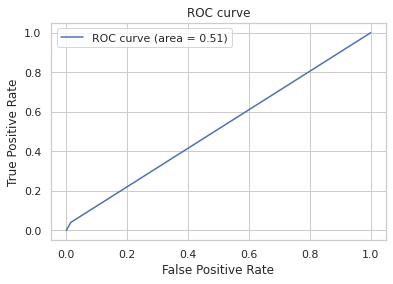

In [169]:
tree = DecisionTreeClassifier(random_state=0, max_depth=25, min_samples_split=100)
tree.fit(x_train,y_train)
Y_pred = tree.predict(x_test)
result(y_test, Y_pred)

【問題4】高い汎化性能のモデル
これまで学んだことを用いながら汎化性能の高いモデルを作成してください。今は全体の流れを掴むことを重視し、Sprintの時間内に結果を出すということも意識しましょう。

In [290]:
df = df_temp #問題3途中から抜き出し

In [291]:
df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3

In [292]:
ohe_columns = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']
df = pd.get_dummies(df, columns=ohe_columns) 

In [293]:
df = df.drop(['NAME_CONTRACT_TYPE_Cash loans', 'CODE_GENDER_F', 'FLAG_OWN_REALTY_N', 'FLAG_OWN_CAR_N'], axis=1)

In [294]:
df = df.dropna(thresh=144, axis=0) #20以上の欠損がある行を削除
df.shape

(110474, 164)

In [295]:
#欠損値処理
df = df.fillna(0)
df = df.select_dtypes(exclude=["object"]) #オブジックト列削除

In [296]:
df_corr = df.corr().abs() #相関関係のデータフレーム作成
df_corr.style.background_gradient(axis=None) #相関係数行列のヒートマップ

In [297]:
selected_cols = df_corr.nlargest(25,'TARGET')['TARGET'].index #TARGETとの相関関係の高い上位25カラム
print(selected_cols)

Index(['TARGET', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCES_PROD', 'AGE',
       'DAYS_BIRTH', 'EXT_SOURCE_1', 'CREDIT_TO_GOODS_RATIO', 'AGE_RANGE',
       'EXT_SOURCES_WEIGHTED', 'NAME_EDUCATION_TYPE_Higher education',
       'REGION_RATING_CLIENT_W_CITY', 'NAME_INCOME_TYPE_Working',
       'REGION_RATING_CLIENT',
       'NAME_EDUCATION_TYPE_Secondary / secondary special', 'CODE_GENDER_M',
       'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED', 'FLAG_DOCUMENT_3', 'FLOORSMAX_AVG',
       'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_GOODS_PRICE', 'EMPLOYED_TO_BIRTH_RATIO'],
      dtype='object')


In [298]:
X = df[['EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCES_PROD', 'AGE',
       'DAYS_BIRTH', 'EXT_SOURCE_1', 'CREDIT_TO_GOODS_RATIO', 'AGE_RANGE',
       'EXT_SOURCES_WEIGHTED', 'NAME_EDUCATION_TYPE_Higher education',
       'REGION_RATING_CLIENT_W_CITY', 'NAME_INCOME_TYPE_Working',
       'REGION_RATING_CLIENT',
       'NAME_EDUCATION_TYPE_Secondary / secondary special', 'CODE_GENDER_M',
       'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED', 'FLAG_DOCUMENT_3', 'FLOORSMAX_AVG',
       'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_GOODS_PRICE', 'EMPLOYED_TO_BIRTH_RATIO']]
y = df['TARGET']

In [299]:
#標準化
scaler = StandardScaler()
X = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

accuracy_score : 87.79%
precision_score : 12.12%
recall_score : 13.22%.
f1_score : 12.65%
confusion_matrix :
[[28802  2125]
 [ 1923   293]]
AUC : 53.18%


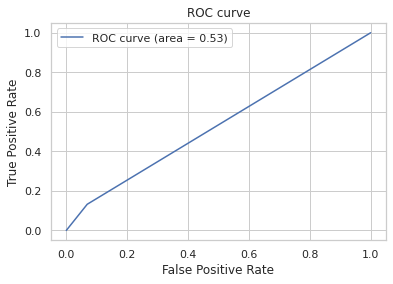

In [321]:
#決定木
tree = DecisionTreeClassifier(random_state=0, max_depth=35, min_samples_split=3)
tree.fit(x_train,y_train)
Y_pred = tree.predict(x_test)
result(y_test, Y_pred)

accuracy_score : 87.97%
precision_score : 11.42%
recall_score : 13.02%.
f1_score : 12.17%
confusion_matrix :
[[2614  194]
 [ 167   25]]
AUC : 53.06%


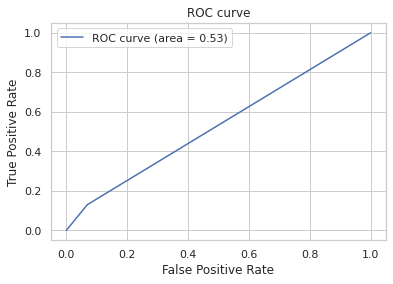

In [285]:
##1-nn
knc_nn1 = KNeighborsClassifier(n_neighbors=1)
knc_nn1.fit(x_train, y_train)
Y_pred = knc_nn1.predict(x_test)
result(y_test, Y_pred)

accuracy_score : 93.60%
precision_score : 0.00%
recall_score : 0.00%.
f1_score : 0.00%
confusion_matrix :
[[2808    0]
 [ 192    0]]
AUC : 50.00%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


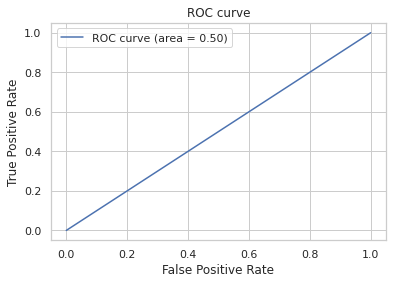

In [289]:
#SVC
clf = SVC(random_state=0)
clf.fit(x_train, y_train)
Y_pred = clf.predict(x_test)
svm = result(y_test, Y_pred)

In [317]:
param_grid = [{
    'max_depth' : [30, 35, 40],
    'min_samples_split' : [3, 4, 5]
}]

In [318]:
estimator = DecisionTreeClassifier(random_state=0)
cv = 5
score = 'recall'

turned_model = GridSearchCV(estimator = estimator,
                            param_grid = param_grid,
                            cv = cv, scoring=score,
                            return_train_score = False)

In [319]:
turned_model.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [30, 35, 40],
                          'min_samples_split': [3, 4, 5]}],
             p

In [320]:
pd.DataFrame(turned_model.cv_results_).T

0  ...                                          8
mean_fit_time                                              1.27795  ...                                    1.30816
std_fit_time                                             0.0136284  ...                                  0.0176142
mean_score_time                                         0.00994592  ...                                 0.00998545
std_score_time                                         9.73352e-05  ...                                0.000233203
param_max_depth                                                 30  ...                                         40
param_min_samples_split                                          3  ...                                          5
params                   {'max_depth': 30, 'min_samples_split': 3}  ...  {'max_depth': 40, 'min_samples_split': 5}
split0_test_score                                         0.126058  ...                                   0.125118
split1_test_score                                         0.146893  ...                                   0.135593
split2_test_score                                          0.13371  ...                                   0.131827
split3_test_score                                         0.141243  ...                                   0.127119
split4_test_score                                         0.145951  ...                                   0.140301
mean_test_score                                           0.138771  ...                                   0.131992
std_test_score                                           0.0078848  ...                                 0.00553259
rank_test_score                                                  4  ...                                          9

[15 rows x 9 columns]